## Installing and so on

In [1]:
%load_ext autoreload
%autoreload 2

Do a `uv sync --extra examples` to install the required dependencies


In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from yanat import generative_game_theoric_pytorch as gen
from yanat import utils as ut
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import netneurotools.datasets as nntd
from scipy.spatial.distance import pdist, squareform

In [3]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("GPU is not available. Using CPU.")


GPU is available. Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 5080


For better plots

In [4]:
from vizman import viz
viz.set_visual_style()

## Fetching a human connectome from netneurotools

In [5]:
human_struct = nntd.fetch_famous_gmat("human_struct_scale033")

Please cite the following papers if you are using this function:
  [primary]:
    
  [celegans]:
    Lav R Varshney, Beth L Chen, Eric Paniagua, David H Hall, and Dmitri B Chklovskii. Structural properties of the caenorhabditis elegans neuronal network. PLoS computational biology, 7(2):e1001066, 2011.
  [drosophila]:
    Ann-Shyn Chiang, Chih-Yung Lin, Chao-Chun Chuang, Hsiu-Ming Chang, Chang-Huain Hsieh, Chang-Wei Yeh, Chi-Tin Shih, Jian-Jheng Wu, Guo-Tzau Wang, Yung-Chang Chen, and others. Three-dimensional reconstruction of brain-wide wiring networks in drosophila at single-cell resolution. Current biology, 21(1):1–11, 2011.
  [human]:
    Alessandra Griffa, Yasser Alemán-Gómez, and Patric Hagmann. Structural and functional connectome from 70 young healthy adults [data set]. Zenodo, 2019.
  [macaque_markov]:
    Nikola T Markov, Maria Ercsey-Ravasz, Camille Lamy, Ana Rita Ribeiro Gomes, Loïc Magrou, Pierre Misery, Pascale Giroud, Pascal Barone, Colette Dehay, Zoltán Toroczkai, and o

In [6]:
human_struct.keys()

dict_keys(['conn', 'coords', 'dist', 'labels'])

In [7]:
connectivity = ut.minmax_normalize(human_struct["conn"])
coordinates = human_struct["coords"]

In [8]:
euclidean_distance = squareform(pdist(coordinates))

<Axes: >

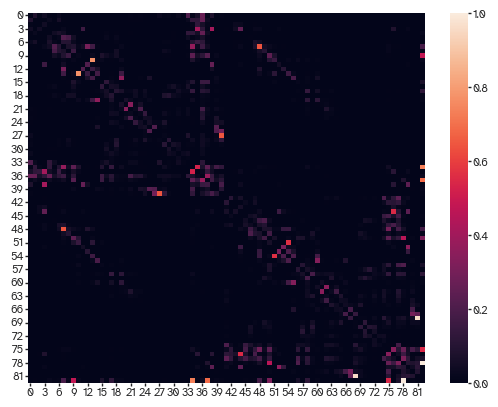

In [9]:
sns.heatmap(connectivity)

Example of how nodes can have different resources based on empirical data. To be the most parsimonious, you can leave this out. To be more topographically accurate, you can include it. Of course you can define this based on anything else you want e.g., genetics or cytoarchitectonic features.

In [10]:
resource = connectivity.sum(0)/(connectivity.sum(0).max()) 

The model is fitted to the density of the empirical connectivity matrix:

In [11]:
ut.find_density(connectivity)

np.float64(0.30976919727101176)

## Fitting the trade-off parameter:

The model has a coefficient for 'wiring benefit' called `alpha` and one to scale wiring cost called `beta`. I usually set that to 1 but note that both (and pretty much all other) parameters can be time-varying. `Penalty` adds a penalty to the payoff for each node, encouraging them to connect to avoid fragmented graphs. This is usually not needed but it can be useful to prevent fragmentation given some metrics. `Batch size` is the number of nodes to be updated at once so higher means slower computation but faster convergence. `Payoff tolerance` is the threshold for the change in payoff to be considered worthy. Think of it as a learning rate. If set to zero, it will converge but will continue going through local updates that are driven by numerical noise (in symmetric networks). In directed graphs, and of course given the metric, it converges to a unique solution that is a Nash Equilibrium. To prevent that little fight after convergence in symmetric networks, you can slowly raise the tolerance to make insignificant payoff differences not worthy. `Weight` is the coefficient of the exponential decay on weights of the generated networks. If this is zero, the networks are evaluated as binary. Otherwise, they'll get weights based on the euclidean distance with longer connections having exponentially less weight. `Resource scaling` is the scaling of the resource available to the nodes. Things depend on the metric so you need to find the right balance for these, or leave them out and just go with `alpha` alone to be the most parsimonious (but also binary). Anyway, let's try this bad boy:

In [12]:
n_iterations = 5000 # this needs to be higher depending on the metric.
beta_vec = np.ones(n_iterations)
penalty_vec = np.zeros(n_iterations)
batch_size_vec = np.full(n_iterations, 10)
payoff_tolerance_vec = 10 * (1 - np.exp(-2 * np.linspace(0, 1, n_iterations)))
weight = 0.1
resource_scaling = 500

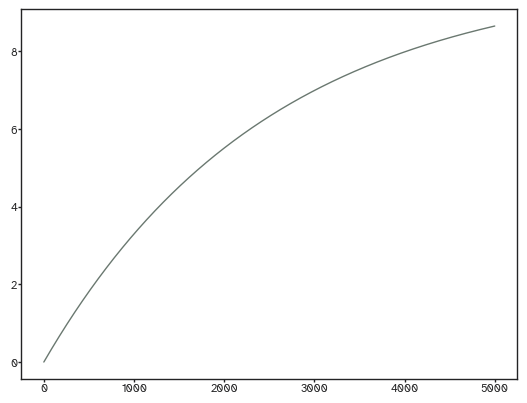

In [13]:
plt.plot(payoff_tolerance_vec)

We'll be using a proxy to propagation dynamics here. Read here if you want to know more about it: https://doi.org/10.7554/eLife.101780
We use a bisection method to find the optimal alpha with a tolerance of 0.01 difference between the empirical and synthetic density. The maximum number of iterations is 10 and I never exceeded it so far.

In [14]:
weighted_history = gen.simulate_network_evolution_gradient_pytorch(
    distance_matrix=euclidean_distance,
    distance_function=gen.heat_kernel_distance_pt,
    n_iterations=200,
    optimization_type="nodal",
    alpha=2.408,
    beta=1,
    learning_rate=0.01,
    random_seed=11,
    symmetric=True,
    verbose=True,
)


Using device: cuda


Simulating (nodal Gradient PyTorch): 100%|██████████| 199/199 [00:06<00:00, 30.15it/s]


<Axes: >

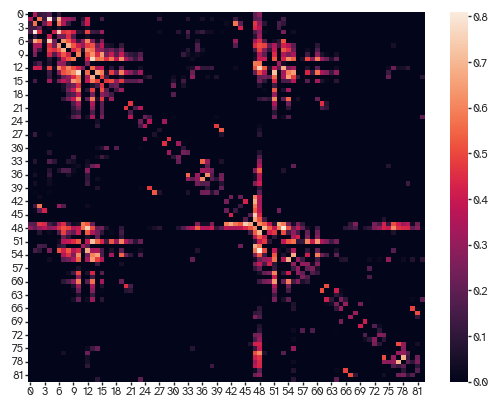

In [15]:
sns.heatmap(weighted_history[...,-1])

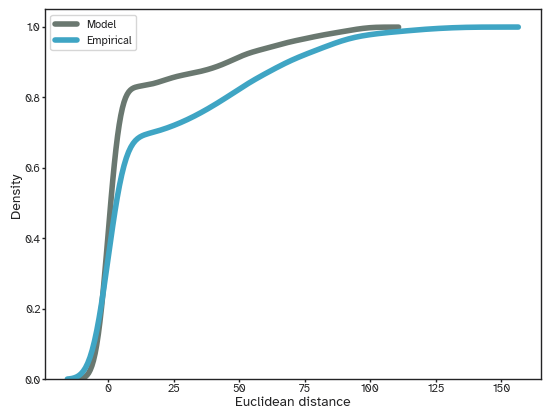

In [16]:
sns.kdeplot((weighted_history[...,-1].astype(bool)*euclidean_distance).flatten(), lw=4, label='Model', cumulative=True)
sns.kdeplot((connectivity.astype(bool)*euclidean_distance).flatten(), lw=4, label='Empirical', cumulative=True)
plt.xlabel('Euclidean distance')
plt.ylabel('Density')
plt.legend()

In [17]:
ut.find_density(weighted_history[...,-1])

np.float64(0.17070692408186966)

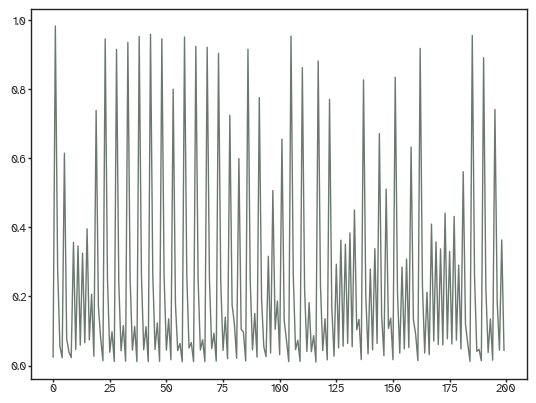

In [18]:
plt.plot(weighted_history.mean((0,1)));

In [55]:
result=gen.find_optimal_alpha_differentiable(
    distance_matrix=euclidean_distance,
    empirical_connectivity=connectivity,
    distance_fn="resistance", # or "heat"
    n_iterations=100,         # Steps of network evolution per alpha update
    alpha_search_iterations=50, # Gradient descent steps for alpha
    initial_alpha=0.01,
    learning_rate_alpha=0.01,  # Learning rate for alpha
    learning_rate_network=0.001, # Learning rate for network evolution
    verbose=True,
    metric="mse",
    optimizer_class="adam", # Use SGD for alpha
    stochastic=False,
    momentum=0.9)

Optimizing Alpha: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it, alpha=0.0580, density=0.0589, loss=0.057635]


In [52]:
result.keys()

dict_keys(['alpha', 'density', 'history', 'final_adjacency'])

In [53]:
from scipy.stats import spearmanr

<Axes: >

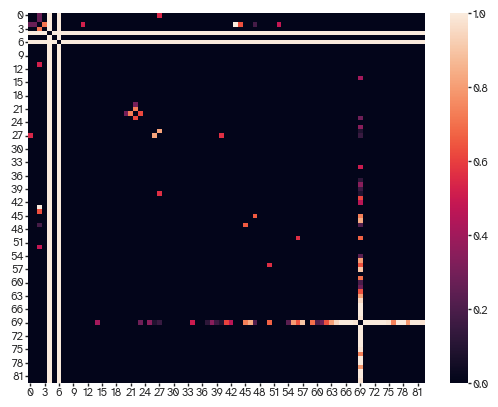

In [56]:
sns.heatmap(result['final_adjacency'])

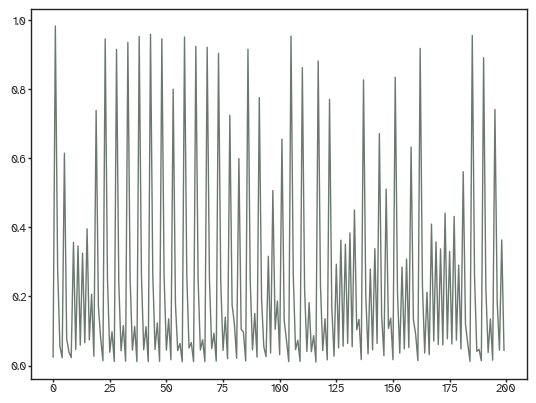

In [36]:
plt.plot(weighted_history.mean((0,1)))

C:\Users\kayso\Downloads\YANAT\yanat\utils.py:49: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


<Axes: >

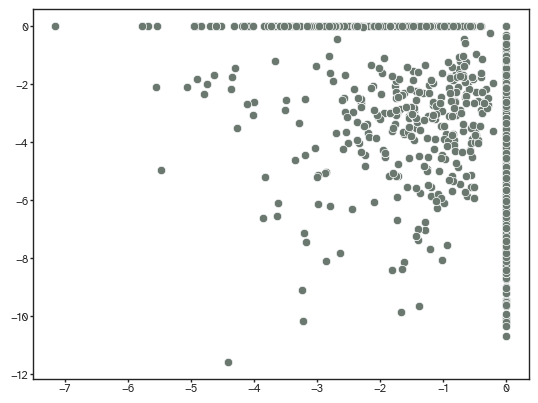

In [23]:
sns.scatterplot(x=ut.log_normalize(weighted_history[...,-1]).flatten(),
 y=ut.log_normalize(connectivity).flatten())

In [24]:
spearmanr(weighted_history[...,-1].flatten(),connectivity.flatten())

NameError: name 'spearmanr' is not defined

This might seem good but I usually test against the value we get just from the euclidean distance.

In [80]:
spearmanr(euclidean_distance.flatten(),connectivity.flatten())

SignificanceResult(statistic=np.float64(-0.4061853909430151), pvalue=np.float64(5.312447132311121e-272))

Meh.

<Axes: >

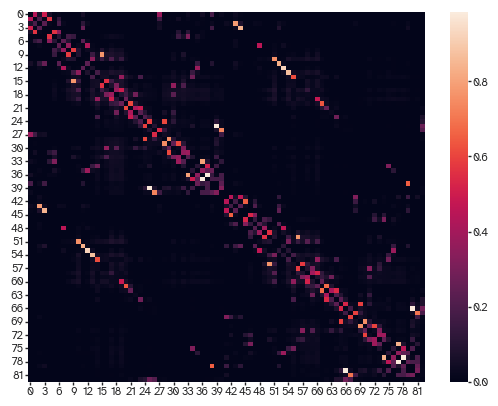

In [81]:
sns.heatmap(weighted_history[...,-1])

C:\Users\kayso\Downloads\YANAT\yanat\utils.py:49: RuntimeWarning: divide by zero encountered in log
  return np.nan_to_num(np.log(adjacency_matrix), neginf=0, posinf=0)


<Axes: >

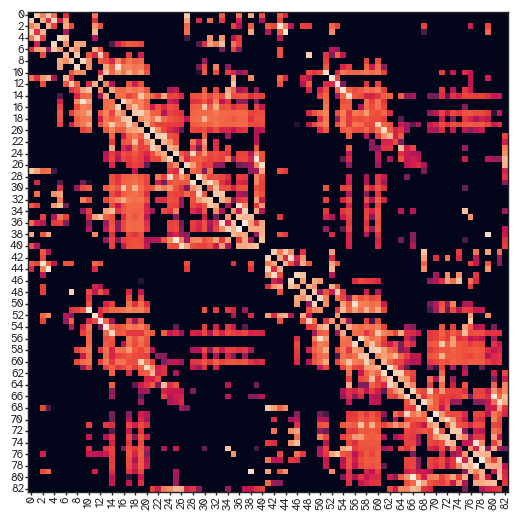

In [82]:
viz.plot_matrix(ut.log_minmax_normalize(weighted_history[...,-1]))

In [52]:
densities = [ut.find_density(result["evolution"][...,i]) for i in range(result["evolution"].shape[-1])]

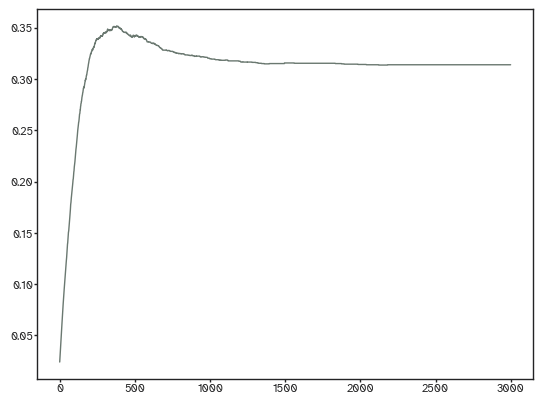

In [53]:
plt.plot(densities);

Nice early-life pruning going on there if you ask me... Anyway, if you have a bunch of empirical networks with the same density, then all you have to do is to use the same parameters to generate synthetic ones. That optimization function is just calling this one under the hood. Here's how to make one:

In [29]:
nets = gen.simulate_network_evolution(
            distance_matrix=euclidean_distance,
            n_iterations=n_iterations,
            distance_fn=gen.heat_kernel_distance,
            alpha=result["alpha"],
            beta=beta_vec,
            connectivity_penalty=penalty_vec,
            n_jobs=-1,
            random_seed=11,
            batch_size=batch_size_vec,
            payoff_tolerance=payoff_tolerance_vec,
            weight_coefficient=weight,
            node_resources=resource*resource_scaling,
            t=0.5,
        )

Simulating (Numba): 100%|██████████| 2999/2999 [00:03<00:00, 828.89it/s]


In [30]:
densities = [ut.find_density(nets[...,i]) for i in range(nets.shape[-1])]

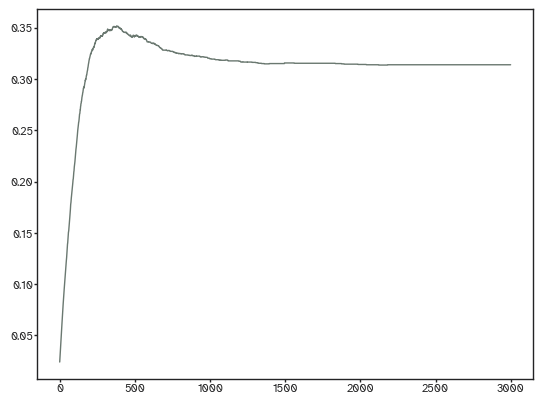

In [31]:
plt.plot(densities);

By default, synthetic networks are binary:

<Axes: >

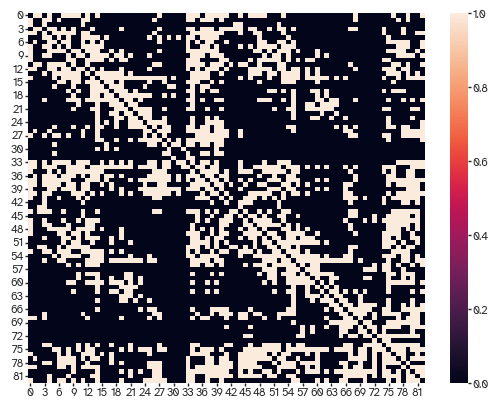

In [32]:
sns.heatmap(nets[...,-1])

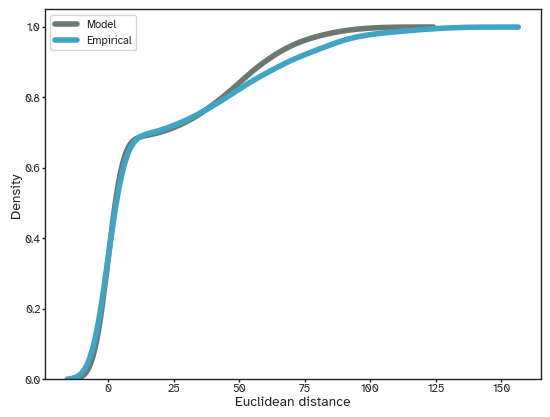

In [34]:
sns.kdeplot((nets[...,-1]*euclidean_distance).flatten(), lw=4, label='Model', cumulative=True)
sns.kdeplot((connectivity.astype(bool)*euclidean_distance).flatten(), lw=4, label='Empirical', cumulative=True)
plt.xlabel('Euclidean distance')
plt.ylabel('Density')
plt.legend()

Missing a bit of long-range connectivity there but I'd say this is pretty good already.We can also check how well the degree distributions match.

<Axes: >

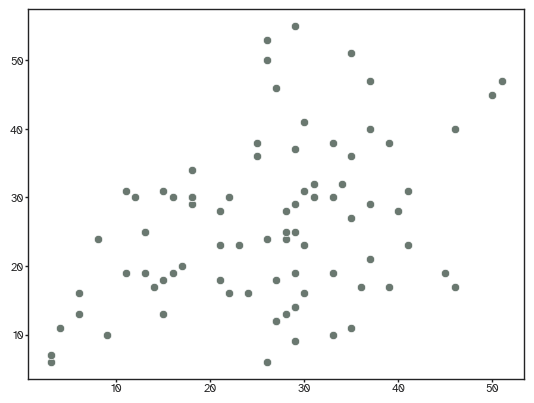

In [35]:
sns.scatterplot(x=nets[..., -1].sum(axis=1), 
y=connectivity.astype(bool).astype(int).sum(axis=1))

And what stuff is missed

<Axes: >

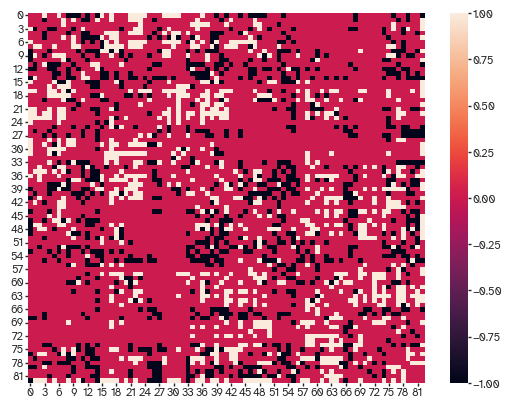

In [36]:
sns.heatmap(connectivity.astype(bool)-nets[...,-1])

we can also look at the cosine similarity between the two networks to see how similar they are.

In [37]:
from yanat.utils import calculate_endpoint_similarity
calculate_endpoint_similarity(connectivity.astype(bool).astype(int), nets[...,-1]).mean()

np.float64(0.5281674444605576)

Not bad actually. But what about the topography, i.e., the spatial distribution of edges

In [38]:
spearmanr(nets[..., -1].sum(axis=1), connectivity.astype(bool).astype(int).sum(axis=1))

SignificanceResult(statistic=np.float64(0.3172947516408696), pvalue=np.float64(0.003469223212342091))

Also not bad but remember the resources have a role here. Anyway, here's an animation showing the whole wiring battle:

In [ ]:
from matplotlib import animation
fig = plt.figure()

ims = []
for i in range(nets.shape[-1]):
    im = plt.imshow(nets[...,i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=100)
from IPython.display import HTML
HTML(ani.to_jshtml())